# Logistic Regression

redo model training with new data in this script

In [1]:
import pandas as pd
import rdata
from sklearn.linear_model import LogisticRegression
import json
from sklearn.model_selection import GroupShuffleSplit
import numpy as np
from functions import get_cv_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

Load data

In [6]:
df_wfc = pd.read_pickle("../data/df_uni_bi_tri_normalized.pickle")
df =df_wfc.reset_index(col_level=1).rename(columns = {'': 'id'}, level =0)

# df_sc = pd.read_pickle("../data/df_uni_bi_tri_normalized_SC.pickle")
# df_ic = pd.read_pickle("../data/df_uni_bi_tri_normalized_IC.pickle")
# df = df_sc.merge(df_ic, on = 'uniform_id')
# df =df.reset_index(col_level=1).rename(columns = {'': 'id'}, level =0)

In [7]:
df.head()


id    TF_uni_WFC                                         \
ia_id uniform_id 1_0001_Samuel 1_0002_Morse, 1_0003_best 1_0004_known   
0           ee_1      0.059849      0.044309    0.000000     0.043049   
1          ee_12      0.147014      0.099674    0.000000     0.128339   
2          ee_16      0.011184      0.080913    0.000000     0.032350   
3          ee_19      0.072944      0.062334    0.065539     0.038904   
4           ee_2      0.055410      0.071429    0.029421     0.038411   

                                                                   ...  \
ia_id 1_0005_today 1_0006_as 1_0007_the 1_0008_inventor 1_0009_of  ...   
0         0.045359  0.000000   0.049769        0.043679  0.028139  ...   
1         0.000000  0.000000   0.000000        0.062975  0.000000  ...   
2         0.012084  0.012009   0.024469        0.046386  0.000000  ...   
3         0.057250  0.035146   0.052940        0.040893  0.018015  ...   
4         0.049689  0.028114   0.000000        0.081890  0.000000  ...   

                                     FF_tri_WFC  \
ia_id 5_0176_them:5_0177_more:5_0178_difficult,   
0                                      0.211079   
1                                      0.127440   
2                                      0.150544   
3                                      0.102987   
4                                      0.182356   

                                                \
ia_id 5_0177_more:5_0178_difficult,:5_0179_but   
0                                     0.211079   
1                                     0.127440   
2                                     0.150544   
3                                     0.129068   
4                                     0.182356   

                                               \
ia_id 5_0178_difficult,:5_0179_but:5_0180_the   
0                                    0.211079   
1                                    0.127440   
2                                    0.150544   
3                                    0.119483   
4                                    0.105971   

                                          \
ia_id 5_0179_but:5_0180_the:5_0181_extra   
0                               0.239733   
1                               0.131779   
2                               0.127075   
3                               0.113018   
4                               0.105971   

                                             \
ia_id 5_0180_the:5_0181_extra:5_0182_effort   
0                                  0.239733   
1                                  0.131779   
2                                  0.273039   
3                                  0.128622   
4                                  0.193115   

                                            \
ia_id 5_0181_extra:5_0182_effort:5_0183_is   
0                                 0.239733   
1                                 0.131779   
2                                 0.273039   
3                                 0.114802   
4                                 0.161915   

                                                                              \
ia_id 5_0182_effort:5_0183_is:5_0184_worth 5_0183_is:5_0184_worth:5_0185_the   
0                                 0.000000                          0.000000   
1                                 0.089479                          0.089479   
2                                 0.145965                          0.087006   
3                                 0.090727                          0.090504   
4                                 0.161915                          0.190963   

                                            \
ia_id 5_0184_worth:5_0185_the:5_0186_added   
0                                 0.111748   
1                                 0.089479   
2                                 0.087006   
3                                 0.123272   
4                                 0.202797   

                                                
ia_id 5_0185_the:5_0186_added:5_018

Add language that is going to be the label/ target for model:

In [8]:
# read df with language:
path_ind_diff = r"../data/version 1.1/primary data/individual differences data/joint.ind.diff.l2.rda"
parsed_readrate = rdata.parser.parse_file(path_ind_diff)
converted_readrate = rdata.conversion.convert(parsed_readrate)
df_readrate = converted_readrate['joint_id'][['uniform_id', 'lang']]

# need multiindex to merge properly:
df_readrate.columns = pd.MultiIndex.from_product([['labels'], df_readrate.columns]) 

# join language
df_main = df.merge(df_readrate, left_on = [('id', 'uniform_id')], right_on= [('labels', 'uniform_id')])
df_main = df_main.drop([('labels', 'uniform_id')], axis=1)

# encode language as lables ( using old lookup json):
with open("../data/outputs/language_lookup.json") as json_file:
    language_lookup = json.load(json_file)

df_main[('labels', 'lang_code')] = df_main[('labels', 'lang')].replace(language_lookup).values

In [ ]:
df_main.columns.get_level_values(0).unique()

In [10]:
df_main[('labels', 'lang')].value_counts()

ee    23
fi    23
ge    23
en    21
sp    21
it    20
he    18
Name: (labels, lang), dtype: int64

In [22]:
# columns used in training

# columns = [ 'TF_uni_POS', 'FP_uni_POS', 'FF_uni_POS', 'TF_bi_POS',
#        'FP_bi_POS', 'FF_bi_POS', 'TF_tri_POS', 'FP_tri_POS', 'FF_tri_POS',
#        'TF_uni_PTB', 'FP_uni_PTB', 'FF_uni_PTB', 'TF_bi_PTB', 'FP_bi_PTB',
#        'FF_bi_PTB', 'TF_tri_PTB', 'FP_tri_PTB', 'FF_tri_PTB', 'TF_uni_UD',
#        'FP_uni_UD', 'FF_uni_UD', 'TF_bi_UD', 'FP_bi_UD', 'FF_bi_UD',
#        'TF_tri_UD', 'FP_tri_UD', 'FF_tri_UD', 'TF_uni_IC', 'FP_uni_IC',
#        'FF_uni_IC', 'TF_bi_IC', 'FP_bi_IC', 'FF_bi_IC', 'TF_tri_IC',
#        'FP_tri_IC', 'FF_tri_IC']

# only uni:
# columns = [ 'TF_uni_POS', 'FP_uni_POS', 'FF_uni_POS', 
#        'TF_uni_PTB', 'FP_uni_PTB', 'FF_uni_PTB',  'TF_uni_UD',
#        'FP_uni_UD', 'FF_uni_UD',  'TF_uni_IC', 'FP_uni_IC',
#        'FF_uni_IC']

columns = [ 'TF_uni_WFC', 'FP_uni_WFC', 'FF_uni_WFC'] # , 'TF_bi_WFC', 'FP_bi_WFC', 'FF_bi_WFC', 'TF_tri_WFC', 'FP_tri_WFC', 'FF_tri_WFC'

## Performance graph

In [19]:
import itertools
from tqdm import tqdm

In [23]:
#only for 4 lang check:
#df_main = df_main[df_main[('labels', 'lang')].isin(['ee', 'fi', 'it', 'sp'])]

dict_performances = {}
dict_performances_groups = []

for i in tqdm(range(2, 8)): # 8
    comb = list(itertools.combinations(['ee', 'fi', 'ge', 'he', 'it', 'en', 'sp'], i))
    #print(comb)
    temp = []
    for c in comb:
        df_main_ = df_main[df_main[('labels', 'lang')].isin(c)]
        logreg = LogisticRegression(C=1e5, multi_class='multinomial', solver='lbfgs', random_state=0)
        #columns = ['TF_uni', 'FP_uni', 'FF_uni', 'TF_bi', 'FP_bi', 'FF_bi', 'TF_tri', 'FP_tri', 'FF_tri' ]
        cross_val_scores = get_cv_score(df_main_, columns, logreg)
        dict_performances[str(c)] = np.mean(cross_val_scores)
        temp.append(np.mean(cross_val_scores))
    dict_performances_groups.append([i, np.mean(temp)])

10it [00:00, 13.07it/s]0:00<?, ?it/s]


0.9578947368421054


10it [00:00, 15.04it/s]


0.9842105263157895


10it [00:00, 16.03it/s]


0.9823529411764707


10it [00:00, 16.68it/s]


0.9888888888888889


10it [00:00, 14.53it/s]


1.0


10it [00:00, 17.11it/s]


0.961111111111111


10it [00:00, 16.25it/s]


0.9210526315789475


10it [00:00, 16.57it/s]


0.7764705882352941


10it [00:00, 16.39it/s]


0.7333333333333333


10it [00:00, 16.77it/s]


1.0


10it [00:00, 15.75it/s]


0.6444444444444445


10it [00:00, 22.75it/s]


0.9058823529411765


10it [00:00, 23.10it/s]


0.9277777777777778


10it [00:00, 23.75it/s]


1.0


10it [00:00, 23.01it/s]


0.95


10it [00:00, 24.04it/s]


0.85


10it [00:00, 19.84it/s]


1.0


10it [00:00, 23.40it/s]


0.775


10it [00:00, 23.49it/s]


1.0


10it [00:00, 21.91it/s]


0.6941176470588235


10it [00:00, 22.83it/s]
 17%|█▋        | 1/6 [00:11<00:58, 11.72s/it]

1.0


10it [00:00, 17.47it/s]


0.9392857142857143


10it [00:00, 22.23it/s]


0.7769230769230769


10it [00:00, 21.87it/s]


0.8148148148148149


10it [00:00, 18.97it/s]


0.9444444444444444


10it [00:00, 20.55it/s]


0.7444444444444444


10it [00:00, 20.16it/s]


0.8807692307692309


10it [00:00, 18.30it/s]


0.9481481481481481


10it [00:00, 21.35it/s]


0.9703703703703704


10it [00:00, 21.56it/s]


0.9


10it [00:00, 16.70it/s]


0.8720000000000001


10it [00:00, 21.99it/s]


0.9560000000000001


10it [00:00, 22.13it/s]


0.8640000000000001


10it [00:00, 18.71it/s]


0.9923076923076923


10it [00:00, 22.03it/s]


0.8076923076923078


10it [00:00, 21.55it/s]


0.9423076923076923


10it [00:00, 18.02it/s]


0.7538461538461538


10it [00:00, 20.89it/s]


0.7925925925925925


10it [00:00, 21.23it/s]


0.9333333333333333


10it [00:00, 18.77it/s]


0.6925925925925925


10it [00:00, 20.48it/s]


0.684


10it [00:00, 21.74it/s]


0.796


10it [00:00, 18.81it/s]


0.5160000000000001


10it [00:00, 21.59it/s]


0.8384615384615385


10it [00:00, 21.11it/s]


0.5461538461538462


10it [00:00, 18.78it/s]


0.7653846153846153


10it [00:00, 22.28it/s]


0.8400000000000001


10it [00:00, 21.84it/s]


0.9


10it [00:00, 17.59it/s]


0.8240000000000001


10it [00:00, 21.36it/s]


0.9538461538461538


10it [00:00, 21.41it/s]


0.7884615384615385


10it [00:00, 17.85it/s]


0.9307692307692308


10it [00:00, 21.95it/s]


0.8708333333333332


10it [00:00, 22.21it/s]


0.6249999999999999


10it [00:00, 10.91it/s]


0.8875


10it [00:00, 20.53it/s]
 33%|███▎      | 2/6 [00:29<01:01, 15.49s/it]

0.788


10it [00:00, 13.44it/s]


0.8371428571428572


10it [00:00, 13.69it/s]


0.8694444444444445


10it [00:00, 15.95it/s]


0.9499999999999998


10it [00:00, 13.58it/s]


0.7805555555555557


10it [00:00, 16.08it/s]


0.7411764705882353


10it [00:00, 13.73it/s]


0.8794117647058822


10it [00:00, 15.59it/s]


0.7


10it [00:00, 13.67it/s]


0.8571428571428571


10it [00:00, 14.78it/s]


0.6599999999999999


10it [00:00, 13.93it/s]


0.8194444444444444


10it [00:00, 14.73it/s]


0.8411764705882353


10it [00:00, 10.39it/s]


0.9647058823529411


10it [00:00, 14.34it/s]


0.8294117647058823


10it [00:00, 15.32it/s]


0.9571428571428571


10it [00:00, 13.57it/s]


0.7657142857142857


10it [00:00, 15.34it/s]


0.9388888888888889


10it [00:00, 11.30it/s]


0.9


10it [00:00, 15.02it/s]


0.7181818181818183


10it [00:00, 14.22it/s]


0.8882352941176469


10it [00:00, 13.64it/s]


0.8617647058823531


10it [00:00, 15.12it/s]


0.7


10it [00:00, 13.11it/s]


0.8676470588235293


10it [00:00, 13.78it/s]


0.6558823529411765


10it [00:00, 12.23it/s]


0.8428571428571427


10it [00:00, 14.99it/s]


0.6371428571428572


10it [00:00, 12.98it/s]


0.7916666666666666


10it [00:00, 14.06it/s]


0.7787878787878788


10it [00:00, 10.64it/s]


0.5212121212121212


10it [00:00, 14.13it/s]


0.6823529411764706


10it [00:00, 12.26it/s]


0.6941176470588235


10it [00:00, 14.97it/s]


0.8606060606060606


10it [00:00, 13.12it/s]


0.6878787878787879


10it [00:00, 15.01it/s]


0.8058823529411765


10it [00:00, 13.10it/s]


0.8176470588235294


10it [00:00, 14.82it/s]
 50%|█████     | 3/6 [00:55<01:01, 20.34s/it]

0.74375


10it [00:00, 10.48it/s]


0.7883720930232557


10it [00:00, 10.63it/s]


0.8522727272727273


10it [00:00, 10.27it/s]


0.740909090909091


10it [00:00, 10.74it/s]


0.8681818181818182


10it [00:00, 11.94it/s]


0.7250000000000001


10it [00:00, 10.41it/s]


0.8044444444444446


10it [00:01,  9.88it/s]


0.7976190476190477


10it [00:01,  9.27it/s]


0.5928571428571427


10it [00:01,  9.22it/s]


0.7279069767441861


10it [00:01,  9.45it/s]


0.7568181818181818


10it [00:00, 11.55it/s]


0.9119047619047619


10it [00:00, 10.68it/s]


0.7285714285714284


10it [00:00, 10.89it/s]


0.8744186046511627


10it [00:00, 10.25it/s]


0.8454545454545453


10it [00:01,  9.98it/s]


0.7857142857142857


10it [00:01,  9.41it/s]


0.7904761904761906


10it [00:01,  9.91it/s]


0.5595238095238095


10it [00:00, 10.62it/s]


0.7209302325581396


10it [00:01,  8.85it/s]


0.7295454545454547


10it [00:01,  9.24it/s]


0.5904761904761905


10it [00:01,  8.51it/s]
 67%|██████▋   | 4/6 [01:17<00:41, 20.75s/it]

0.75


10it [00:02,  4.60it/s]


0.826923076923077


10it [00:01,  5.09it/s]


0.6557692307692309


10it [00:01,  5.14it/s]


0.7461538461538462


10it [00:02,  4.93it/s]


0.7584905660377358


10it [00:02,  4.45it/s]


0.6823529411764706


10it [00:02,  4.49it/s]


0.7607843137254902


10it [00:01,  5.75it/s]
 83%|████████▎ | 5/6 [01:31<00:18, 18.48s/it]

0.6490196078431373


10it [00:02,  4.39it/s]
100%|██████████| 6/6 [01:34<00:00, 15.68s/it]

0.695


In [24]:
# dict_performances
dict_performances_groups_uni = dict_performances_groups

print(dict_performances_groups_tri)
print(dict_performances_groups_bi)
print(dict_performances_groups_uni)

dict_performances_groups

[[2, 0.9130714859043032], [3, 0.8409298622012907], [4, 0.7914061488231656], [5, 0.7521809456693178], [6, 0.7243540957747395], [7, 0.7033333333333334]]
[[2, 0.9110215284944386], [3, 0.8425534624106052], [4, 0.7994360486618891], [5, 0.7620587060288057], [6, 0.7315657612827424], [7, 0.6983333333333334]]
[[2, 0.9072636657001981], [3, 0.8308652247223677], [4, 0.79562775110044], [5, 0.7591141441307554], [6, 0.7256419403755697], [7, 0.695]]


[[2, 0.9072636657001981],
 [3, 0.8308652247223677],
 [4, 0.79562775110044],
 [5, 0.7591141441307554],
 [6, 0.7256419403755697],
 [7, 0.695]]

trigrams:

[[2, 0.9130714859043032],
 [3, 0.8409298622012907],
 [4, 0.7914061488231656],
 [5, 0.7521809456693178],
 [6, 0.7243540957747395],
 [7, 0.7033333333333334]]

bigrams:

[[2, 0.9110215284944386],
 [3, 0.8425534624106052],
 [4, 0.7994360486618891],
 [5, 0.7620587060288057],
 [6, 0.7315657612827424],
 [7, 0.6983333333333334]]


unigrams:

[[2, 0.9072636657001981],
 [3, 0.8308652247223677],
 [4, 0.79562775110044],
 [5, 0.7591141441307554],
 [6, 0.7256419403755697],
 [7, 0.695]]

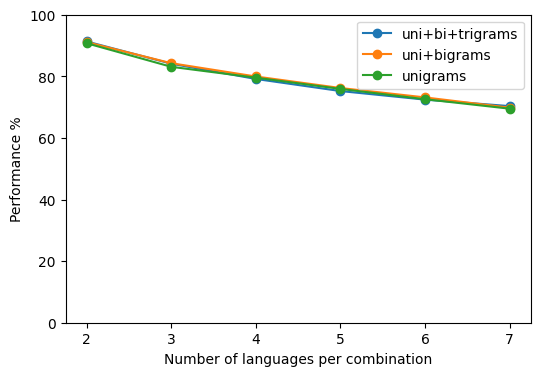

In [25]:
fig, axes = plt.subplots(ncols=1, figsize=(6,4))
axes.plot(np.array(dict_performances_groups_tri)[:, 0],
        [i * 100 for i in  np.array(dict_performances_groups_tri)[:, 1]], marker='o', label = 'uni+bi+trigrams')
axes.plot(np.array(dict_performances_groups_bi)[:, 0],
        [i * 100 for i in  np.array(dict_performances_groups_bi)[:, 1]], marker='o', label = 'uni+bigrams')
axes.plot(np.array(dict_performances_groups_uni)[:, 0],
        [i * 100 for i in  np.array(dict_performances_groups_uni)[:, 1]], marker='o', label = 'unigrams')
# mean performance per group of all combinations of languages
#axes.set_title(' Mean performance per group of all possible combinations of languages. E.g. 2 on the x axis means a group all language pairs amd y shows the mean performance.')
axes.legend()
axes.set_xlabel('Number of languages per combination')
axes.set_ylabel('Performance %')
axes.set_ylim(0, 100);

## LogReg NLIR

In [9]:
# defining model with correct solver
logreg = LogisticRegression(C=1e5, multi_class='multinomial', solver='lbfgs', random_state=0)

Cross validation score: 

(only needed for report and not for further coding)

In [11]:
cross_val_scores = get_cv_score(df_main, columns, logreg)
print(np.mean(cross_val_scores))
#cross_val_scores # [0.65, 0.5666666666666667, 0.6, 0.5166666666666667, 0.5666666666666667]

0it [00:00, ?it/s]/mnt/c/Users/linas/OneDrive/Documents/ITU/Semester3/NLP/NLP_project/ANLP_project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
1it [00:00,  4.53it/s]/mnt/c/Users/linas/OneDrive/Documents/ITU/Semester3/NLP/NLP_project/ANLP_project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modul

0.43
0.43


In [12]:
# real train-test split to be used for further analysis: 
train_subset = df_main[columns]
train_label_subset = df_main[('labels', 'lang_code')]

gss = GroupShuffleSplit(n_splits=5, test_size = 0.3, random_state=42)
split_indexes = list(gss.split(train_subset, train_label_subset, df_main[('id','uniform_id')]))[0]
train_idx = list(split_indexes[0])
test_idx = list(split_indexes[1])

X_train = train_subset.iloc[train_idx]
y_train = train_label_subset.iloc[train_idx]
X_test = train_subset.iloc[test_idx]
y_test = train_label_subset.iloc[test_idx]

test_lang = df_main[('labels', 'lang')].iloc[test_idx]
test_lang_codes = df_main[('labels', 'lang_code')].iloc[test_idx]

In [13]:
# fit model:
logreg.fit(X_train, y_train)

# only for score count:
y_pred = logreg.predict(X_test)
test_acc_score = accuracy_score(y_test, y_pred)
print(f'Test set accuracy: {test_acc_score}; overall cross validation accuracy {np.mean(cross_val_scores)}')
# Test set accuracy: 0.6888888888888889; overall cross validation accuracy 0.5800000000000001 for all languages
# Test set accuracy: 0.4074074074074074; overall cross validation accuracy 0.4914285714285714 for 4 languages


Test set accuracy: 0.4666666666666667; overall cross validation accuracy 0.43


/mnt/c/Users/linas/OneDrive/Documents/ITU/Semester3/NLP/NLP_project/ANLP_project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test set accuracy: 0.7857142857142857; overall cross validation accuracy 0.6736842105263158 for ee - fi (46)

Test set accuracy: 0.8571428571428571; overall cross validation accuracy 0.711111111111111 for ee - sp (44)

Test set accuracy: 0.7692307692307693; overall cross validation accuracy 0.8 for ee -it  (43)

Test set accuracy: 0.5384615384615384; overall cross validation accuracy 0.8222222222222222 fi it (43)

Test set accuracy: 0.5714285714285714; overall cross validation accuracy 0.6555555555555556 fi sp (44)

Test set accuracy: 0.7692307692307693; overall cross validation accuracy 0.6823529411764706 it sp (41)



Test set accuracy: 0.5238095238095238; overall cross validation accuracy 0.5407407407407407 ee fi sp 

Test set accuracy: 0.55; overall cross validation accuracy 0.6814814814814815 ee fi it

Test set accuracy: 0.55; overall cross validation accuracy 0.6923076923076923 ee sp it

Test set accuracy: 0.5; overall cross validation accuracy 0.6538461538461539 fi sp it



















### LogReg Similarity

Create dictionary with df for each language separately to be used for similarity metrics:

In [14]:
X_test['lang'] = test_lang # add language column
languages = list(test_lang.unique())
dict_lang = {}
for ll in languages:
    df = X_test[X_test['lang'] == ll]
    dict_lang[ll] = df


dict_proba ={}
len_dfs = []
lang_identifier = []
for key in dict_lang.keys():
    lang_df = dict_lang[key][columns]
    test_proba = logreg.predict_proba(lang_df) # predicting probabilities here
    len_df = len(lang_df) 
    test_proba = test_proba.sum(axis=0)   # sum bc they are normalised by number of participants
    dict_proba[key] = test_proba
    len_dfs.append(len_df) # record length of language df
    lang_identifier.append(key)

/tmp/ipykernel_438/2390796384.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['lang'] = test_lang # add language column


In [15]:
# to pandas:
df_predictions = pd.DataFrame(dict_proba).reset_index()
# cols are lang on which predicted and rows are outputs

# add col with lenghts and lang name
df_predictions['length'] = len_dfs
df_predictions['lang'] = lang_identifier

In [16]:
df_predictions # is length th enum of participants in test set?

,index,ee,en,fi,ge,he,it,sp,length,lang
0,0,4.381449e+00,2.393253e-02,1.963345e-06,2.003049e-04,2.569414e-03,1.620103e-03,1.744783e-02,10,ee
1,1,7.123241e-08,6.081864e+00,1.539426e-07,2.261463e-10,1.829007e-07,9.565856e-08,2.601359e-10,8,en
2,2,1.382471e+00,9.409954e-01,3.431288e+00,5.476404e-01,9.350449e-01,1.146260e+00,2.088547e+00,6,fi
3,3,1.584717e+00,6.236203e-04,1.620513e+00,5.407999e+00,6.915152e-01,2.817639e-01,1.324328e-02,8,ge
4,4,5.444984e-03,3.955529e-03,7.888608e-01,2.260434e-02,3.460183e-01,2.558418e-01,6.815443e-01,2,he
5,5,1.640062e+00,6.726959e-07,8.293699e-03,1.701423e+00,1.584464e-02,1.836888e+00,1.059521e+00,6,it
6,6,1.005856e+00,9.486285e-01,1.510420e-01,3.201331e-01,9.007350e-03,2.477626e+00,1.139696e+00,5,sp


Convert into pair dictionary:

In [17]:
lang_values = []
lang_pairs = []
#lang_similarities = {}
for key1 in df_predictions['lang'].unique(): 
    for key2 in df_predictions['lang'].unique(): 
        val1 = float(df_predictions[df_predictions['lang'] == key1][key2])
        val2 = float(df_predictions[df_predictions['lang'] == key2][key1])
        len1 = float(df_predictions[df_predictions['lang'] == key1]['length'])
        len2 = float(df_predictions[df_predictions['lang'] == key2]['length'])
        
        #lang_similarities[f'{key1}_{key2}'] = ((val1 + val2) /(len1+len2)) #  divide by corpus length bc summed above
        lang_values.append((val1 + val2) / (len1+len2))
        lang_pairs.append(f'{key1}_{key2}')

In [18]:
df_lang_similarities = pd.DataFrame({'pair': lang_pairs, 'logreg_val': lang_values})

In [19]:
# inverted 
df_lang_similarities['logreg_val_inverted'] = 1 - df_lang_similarities['logreg_val']

In [20]:
#lang_similarities # invert as 1- proba. 
df_lang_similarities

,pair,logreg_val,logreg_val_inverted
0,ee_ee,4.381449e-01,0.561855
1,ee_en,1.329589e-03,0.998670
2,ee_fi,8.640455e-02,0.913595
3,ee_ge,8.805097e-02,0.911949
4,ee_he,6.678665e-04,0.999332
5,ee_it,1.026051e-01,0.897395
6,ee_sp,6.822027e-02,0.931780
7,en_ee,1.329589e-03,0.998670
8,en_en,7.602330e-01,0.239767
9,en_fi,6.721397e-02,0.932786


In [21]:
# write 

df_lang_similarities.to_csv("../data/outputs/logreg_similarity_SC_IC_uni.csv", index = False) # rename for other saves

**ToDos:**

- investigate why 4 lang perform worse than all. maybe try with 2? ( very different and very similar - eg ee vs fi and ee and sp)
- do separate runs with only bi and bi+tri-grams and fill table in report
- plot language tree using both similarity metrics
- do majority class baseline (cv accuracy only)

